# Part I - Prosper Load Data Exploration
## by Zukhriddin Juliev


## Table of Contents
1. [Intorduction](#1)
2. [Preliminary Wrangling](#2)
3. [Univariate Exploration](#3)
4. [Bivariate Exploration](#4)
5. [Multivariate Exploration](#5)
6. [Conclusion](#6)
6. [References](#ref)

## Introduction
<a id = '1'></a>
In this project, I will investigate factors defining investor numbers for a loan. I will use Prosper loan data. This is a firm which offers a platform for peer-to-peer loan matching service. The dataset allows to investigate wide range of questions related with loan service, delinquency, profitablity etc. I am interested in factors impacting attractiveness of loans to investors. The data contains information on the  number of investors invested in the loan. Many loans have only 1 investor, that is borrower was able to find only 1 investor to borrow from. However, there are also many loans which attracted more than 100 investors. This is a good question, because knowing factors impacting attractiveness of loans may enhance matching process and consequently accelerate financing of promisable projects.
In order to not deal with price increases (inflation), I will restrict data sample to year 2013. This is a year which has the most complete observations. Among variables, only occupation and debt to income ratio columns suffer from negligent missing values. 


## Preliminary Wrangling
<a id = '2'></a>

In [1]:
# Loading necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
plt.style.use('seaborn') ## I use this plot style for most of the plots. But I also use other plot style later.

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
## Loading the data and leaving observations with loans only for year 2013
df = pd.read_csv("prosperLoanData.csv")
## Converting loan origination date to timestamp and choosing loans for year 2013
df['LoanOriginationDate'] = pd.to_datetime(df["LoanOriginationDate"]).dt.normalize()
year = df['LoanOriginationDate'].dt.year
df = df[year == 2013]

The dataset has 433 duplicated loans due to being recorded at different dates. Since, I do not need information on loan payment progress I will remove any duplicates leaving one randomly.

In [3]:
df = df.drop_duplicates(subset = 'LoanNumber') ### Removing duplicates
df.duplicated().sum() ## Checking number of duplicates

0

In [4]:
df.shape

(33912, 81)

In [5]:
df.columns

Index(['ListingKey', 'ListingNumber', 'ListingCreationDate', 'CreditGrade',
       'Term', 'LoanStatus', 'ClosedDate', 'BorrowerAPR', 'BorrowerRate',
       'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
       'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperRating (Alpha)',
       'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState',
       'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration',
       'IsBorrowerHomeowner', 'CurrentlyInGroup', 'GroupKey',
       'DateCreditPulled', 'CreditScoreRangeLower', 'CreditScoreRangeUpper',
       'FirstRecordedCreditLine', 'CurrentCreditLines', 'OpenCreditLines',
       'TotalCreditLinespast7years', 'OpenRevolvingAccounts',
       'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries',
       'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years',
       'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
       'RevolvingCreditBalance', 'BankcardUtilization',
       'Availa

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33912 entries, 4 to 113934
Data columns (total 81 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   ListingKey                           33912 non-null  object        
 1   ListingNumber                        33912 non-null  int64         
 2   ListingCreationDate                  33912 non-null  object        
 3   CreditGrade                          0 non-null      object        
 4   Term                                 33912 non-null  int64         
 5   LoanStatus                           33912 non-null  object        
 6   ClosedDate                           2623 non-null   object        
 7   BorrowerAPR                          33912 non-null  float64       
 8   BorrowerRate                         33912 non-null  float64       
 9   LenderYield                          33912 non-null  float64       
 10  Estimated

### What is the structure of your dataset?

- Data contains 33 912 observations with 81 features. Every observation contains traditional information on loans such as term, interest rate, amount and objective of the loan. Besides, there are also other wide range of information about loan current status (delinquent, default, completed etc.), borrowers credit background and also information for investors.
- The columns are of different formats and need to be cleaned and tidyed.

### What is/are the main feature(s) of interest in your dataset?

- My main feature of interest is 'Investors' column. This column contains information on the number of investors who invested on the loan. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I believe, following features would be essential in investigating the question

1. Profitablity: 
    * Investor number, Estimated Return

2. Loan conditions: 
    * Term, Borrower rate, Loan Original Amount Listing Category (purpose of loan)

3. Borrower characteristics: 
    * Employment characteristics (Occupation, Employment status), Borrower Location State, Income characteristics (income range), Debt and Asset ownership (Debt to Income ratio, Home Owenership status) and Credit history (total credit line in past 7 years, Delinquencies in last 7 years)
    
#### Some needed corrections prior to investigation
1. Income range is not ordered. It needs to be converted to ordered categorical variable.
    
    
2. The category of the loan is given in only numeric codes. We need to look at the text version to identify most frequent category. The category should be coded as listing category as below (see reference for the source):

0 - Not Available, 1 - Debt Consolidation, 2 - Home Improvement, 3 - Business, 4 - Personal Loan, 5 - Student Use, 6 - Auto, 7- Other, 8 - Baby&Adoption, 9 - Boat, 10 - Cosmetic Procedure, 11 - Engagement Ring, 12 - Green Loans, 13 - Household Expenses, 14 - Large Purchases, 15 - Medical/Dental, 16 - Motorcycle, 17 - RV, 18 - Taxes, 19 - Vacation, 20 - Wedding Loans
   
    
3. Converting boolean type of HomeOwnership variable into string [Yes, No] variable.

In [7]:
# Making income range ordered categorical type
income_ranges = ['Not employed', '$0', '$1-24,999', '$25,000-49,999', 
                 '$50,000-74,999', '$75,000-99,999', '$100,000+']
income_classes = pd.api.types.CategoricalDtype(ordered=True, categories=income_ranges)
# Use pandas.astype() to convert the "IncomeRange" column from a plain object type into an ordered categorical type 
df['IncomeRange'] = df['IncomeRange'].astype(income_classes)
# Test
df['IncomeRange'].dtypes

CategoricalDtype(categories=['Not employed', '$0', '$1-24,999', '$25,000-49,999',
                  '$50,000-74,999', '$75,000-99,999', '$100,000+'],
, ordered=True)

In [8]:
# Converting numeric categories into text categories
category = {0:'Not Available', 1:'Debt Consolidation', 2:'Home Improvement',
            3:'Business', 4:'Personal Loan', 5:'Student Use', 6:'Auto', 7:'Other',
            8:'Baby&Adoption', 9:'Boat', 10:'Cosmetic Procedure', 
            11:'Engagement Ring', 12:'Green Loans', 13:'Household Expenses', 
            14:'Large Purchases', 15:'Medical/Dental', 16:'Motorcycle', 
            17:'RV', 18:'Taxes', 19:'Vacation', 20:'Wedding Loans'}
# Creating a column with text values
df['ListingCategory (text)'] = df['ListingCategory (numeric)'].replace(category) 
# Test
df[['ListingCategory (text)', 'ListingCategory (numeric)']].sample(3)

,ListingCategory (text),ListingCategory (numeric)
56403,Debt Consolidation,1
60113,Auto,6
91490,Auto,6


In [9]:
### Converting homeownership into string Yes and No
df['IsBorrowerHomeowner'] = df['IsBorrowerHomeowner'].replace({True:'Yes', False: 'No'})
df['IsBorrowerHomeowner'].head(3)

4    Yes
5    Yes
6     No
Name: IsBorrowerHomeowner, dtype: object

In [10]:
### Subsetting the dataset with the variables of interest
variables = ['Investors', 'EstimatedReturn', 
             'Term', 'BorrowerRate', 'LoanOriginalAmount', 'ListingCategory (text)',
             'BorrowerState', 'Occupation', 'EmploymentStatus','IsBorrowerHomeowner', 
             'IncomeRange', 'DebtToIncomeRatio', 
             'TotalCreditLinespast7years', 'DelinquenciesLast7Years']
df = df[variables].reset_index()

In [11]:
df.shape

(33912, 15)

### Creating some stand alone functions for frequently used plots

In [12]:
### Scatter plot function
def plot_scatter(df, x_col, y_col, title = '', x_label = '', y_label = '', s = 4, alpha = 0.3):
    """ This is a function to plot a scatter plot.
    
    Args:
        df - Dataframe name
        x_col, y_col - columns on x and y axis respectively
        x_label, y_label - labes for x and y axis respectively
        s = size of the markers, default set to 4
        alpha = transparency of the points, default set to 0.3
    Returns:
        scatter plot
    """
    plt.scatter(data = df, x = x_col, y = y_col, s = s, color = 'brown', alpha = alpha)
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
### Bar plot function
def plot_bar(x, title = '', x_label = ''):
    """ This is a function to plot a bar plot.
    
    Args:
        x - data series
        title  - name of the plot
        x_label - labels for x axis
        color - color of the bars
    Returns:
        bar plot
    """
    x.plot.barh(color = 'brown')
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label)
    plt.grid(linestyle='dashed')
    plt.show()
    
def plot_boxplot(df, x_col, y_col, title = '', x_label = '', y_label = ''):
    """ This is a function to plot a box plot via seaborn package.
    
    Args:
        df - Dataframe name
        title - title of the plot
        x_col, y_col - columns on x and y axis respectively
        x_label, y_label - labels for x and y axis respectively
    Returns:
        box plot
    """
    sb.boxplot(data = df, x=x_col, y=y_col, color = 'gray')
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

## Univariate Exploration
<a id ='3'></a>

In this section, I will investigate distributions of individual variables. In total I have 15 variables with 33912 loans.


### 1.1: What is the distribution of investors?
Our main interest is number of investors per loan. More than 25% of the loans have only one investor. However, we are interested in loans with multiple investors. For simplification we will look at the plot of distribution of loans with investor number greater or equal to 5. 

In [13]:
## Below code confirms that distribution is highly skewed to single-investor loans.
df['Investors'].describe()

count    33912.000000
mean        55.734607
std         94.627170
min          1.000000
25%          1.000000
50%          1.000000
75%         75.000000
max        779.000000
Name: Investors, dtype: float64

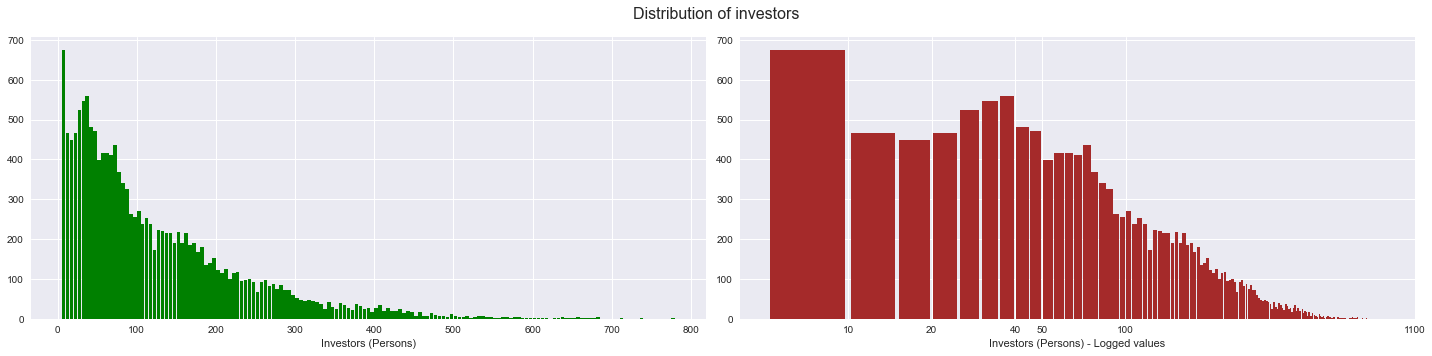

In [14]:
# PLot of distribution of loans with investor number greater or equal to 5.
binsize = 5
bins = np.arange(5, df['Investors'].max() + binsize, binsize)

fig, axes = plt.subplots(1, 2, figsize =[20,5])
fig.suptitle('Distribution of investors', fontsize = 16)

axes[0].hist(data = df, x = 'Investors', bins = bins, color = 'green', rwidth = 0.90)
axes[0].set_xlabel('Investors (Persons)')

axes[1].hist(data = df, x = 'Investors', bins = bins, color = 'brown', rwidth = 0.90)
axes[1].set_xscale('log')
axes[1].set_xticks([10, 20, 40, 50, 100, 1100], [10, '20', '40', '50', '100', '1100'])
axes[1].set_xlabel('Investors (Persons) - Logged values')

fig.tight_layout()
plt.show()

As expected, the distribution of investor numbers are very skewed to the lowest number of under 10. However, the distribution have a second mode and it is a type of loans which attract about 35 to 40 investors. There are also loans which attract more than 100 investors. 

### 1.2: What is the distribution of Estimated returns from loans?

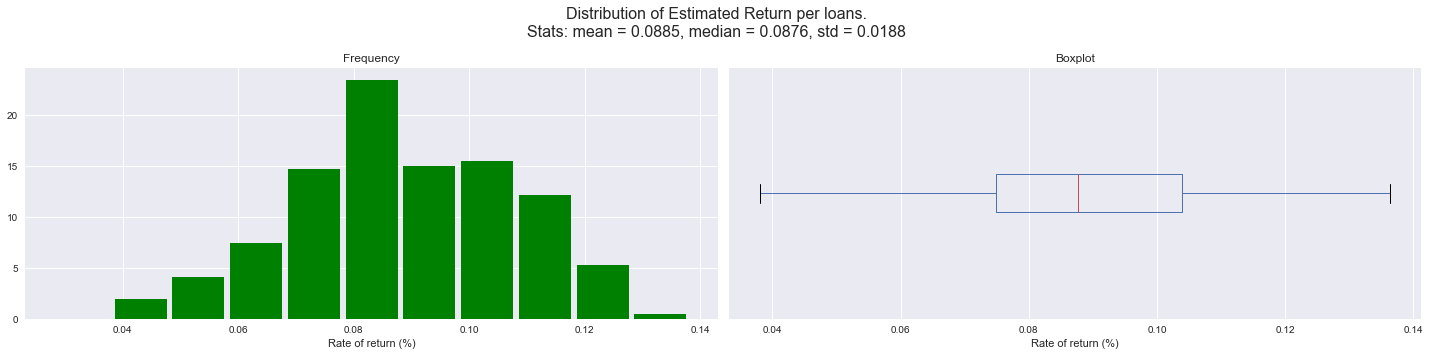

In [15]:
## Getting main statistics
mean = round(df['EstimatedReturn'].mean(),4)
median = round(df['EstimatedReturn'].median(),4)
std = round(df['EstimatedReturn'].std(),4)

fig, axes = plt.subplots(1, 2, figsize =[20,5])
fig.suptitle('Distribution of Estimated Return per loans.\nStats: mean = {}, median = {}, std = {}'.format(mean, median, std), 
             fontsize = 16)

binsize = 0.01
bins = np.arange(df['EstimatedReturn'].min() - binsize, df['EstimatedReturn'].max() + binsize, binsize)

df.hist('EstimatedReturn', bins = bins, color = 'green', rwidth = 0.90, ax = axes[0], density = True)
axes[0].set_xlabel('Rate of return (%)')
axes[0].set_title("Frequency")

df.boxplot('EstimatedReturn', vert = False, ax = axes[1])
axes[1].set_xlabel('Rate of return (%)')
axes[1].set_yticks([])
axes[1].set_title('Boxplot')
fig.tight_layout()
plt.show()

Distribution of estimated returns is quite symmetric. The estimated returns varies around 0.9 points with standard deviation of 0.02.

### 1.3 Distribution of loan terms and borrower rate

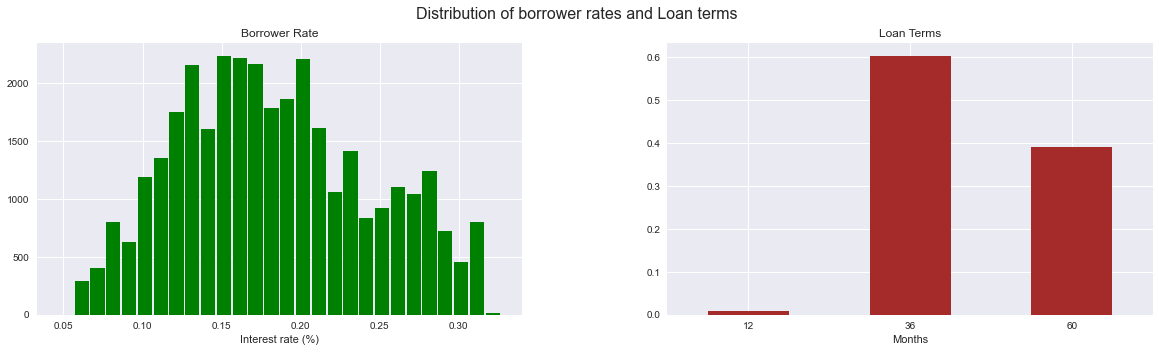

In [16]:
fig, axes = plt.subplots(1, 2, figsize =[20,5])
fig.suptitle('Distribution of borrower rates and Loan terms', 
             fontsize = 16)

binsize = 0.01
bins = np.arange(df['BorrowerRate'].min() - binsize, df['BorrowerRate'].max() + binsize, binsize)

df.hist('BorrowerRate', bins = bins, color = 'green', rwidth = 0.90, ax = axes[0])
axes[0].set_xlabel('Interest rate (%)')
axes[0].set_title("Borrower Rate")

df['Term'].sort_values().value_counts(sort = False, normalize = True).plot.bar(ax = axes[1], color = 'brown')
axes[1].set_xlabel('Months')
axes[1].set_title('Loan Terms')
axes[1].set_xticklabels(['12', '36', '60'], rotation = 360)
plt.show()

* Borrower rate is quite symmetric and ranges from 0.06 to over 0.3 points. It does suffer much from outlier issue.
* Close to 60% of loans are done for 3 year period (36 months). The next frequent loan term is 5 years (about 40%). Very few loans are obtained for 1 year term.

### 1.4: Original Amount of Loans

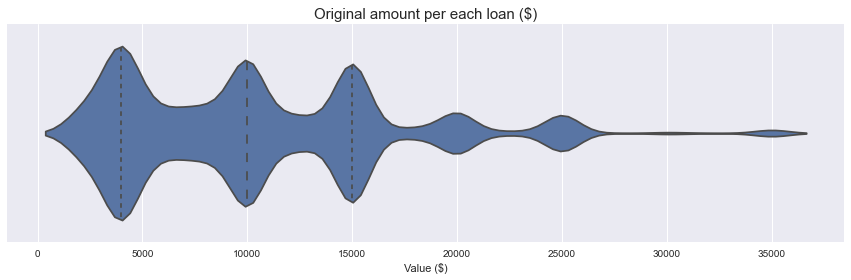

In [17]:
# PLots of distribution Loan Original Amount and Monthly Loan Payment
plt.figure(figsize = [15,4])
sb.violinplot(data=df, x='LoanOriginalAmount', inner = 'quartile')
plt.title('Original amount per each loan ($)', fontsize = 15)
plt.xlabel('Value ($)')
fig.tight_layout()
plt.show()

Loan values are highly skewed. There are outliers (loans ranging above 30k). Majority of loans are between 5k to 15k. 

### 1.5 What is the most frequent borrowing category and where is the location state of borrowers?

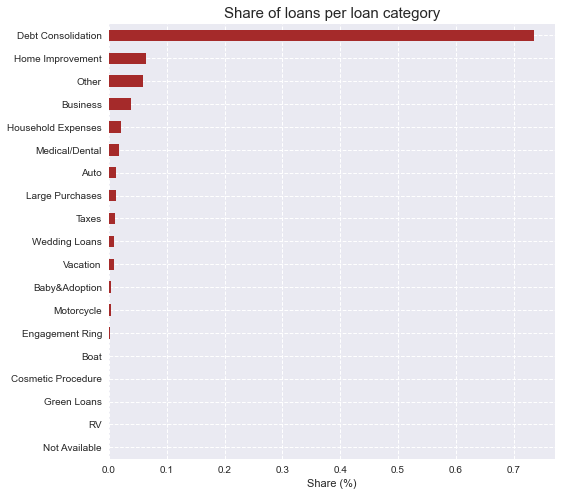

In [18]:
## PLotting loan share per category
plt.figure(figsize = [8,8])
x  = df['ListingCategory (text)'].value_counts(ascending = True, normalize=True)
plot_bar(x, x_label = 'Share (%)', title = 'Share of loans per loan category')

In [19]:
## Sum of top and lowest 5 categories
top5 = ['Debt Consolidation', 'Home Improvement', 'Business', 'Household Expenses', 'Medical/Dental']
last5 = ['Boat', 'RV', 'Cosmetic Procedure', 'Green Loans', 'Not Available']
t5 = df['ListingCategory (text)'].value_counts(ascending = True, normalize=True)[top5].sum()
l5 = df['ListingCategory (text)'].value_counts(ascending = True, normalize=True)[last5].sum()
print('Share of top 5 categories in total: {}'.format(t5.round(3)))
print('Share of least 5 categories in total: {}'.format(l5.round(3)))

Share of top 5 categories in total: 0.877
Share of least 5 categories in total: 0.003


Majority of loans are under debt consolidation category (more than 60% of loans). Next frequent categories after category 'Other' are Home imporvement, business and auto category. Share of loans in top 5 categories equal to 87.7%, while least five is even lower than 1%.

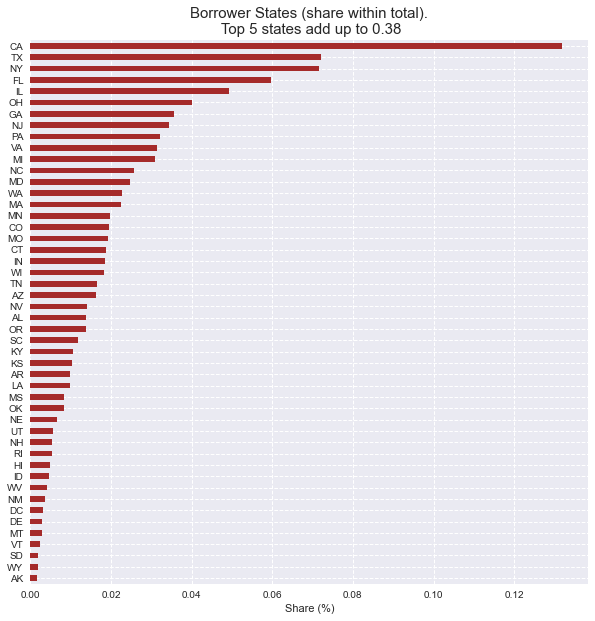

In [20]:
### Plotting state of the borrowers per their share in total
plt.figure(figsize = [10,10])
top5 = df['BorrowerState'].value_counts(ascending = False, normalize =True).head(5).sum() ## sum of share of top 5 states
x = df['BorrowerState'].value_counts(ascending = True, normalize =True)
plot_bar(x, x_label = 'Share (%)', 
          title = 'Borrower States (share within total).\n Top 5 states add up to {}'.format(top5.round(2)))

California, New York, Texas, Florida and Illinois are the most frequent states of the borrowers. Top 5 states add up to 38% of all loanes.

### 1.6 What is the employment characteristics of the borrower?
There are many occupations. Therefore, we would better look at the most frequent ones. 

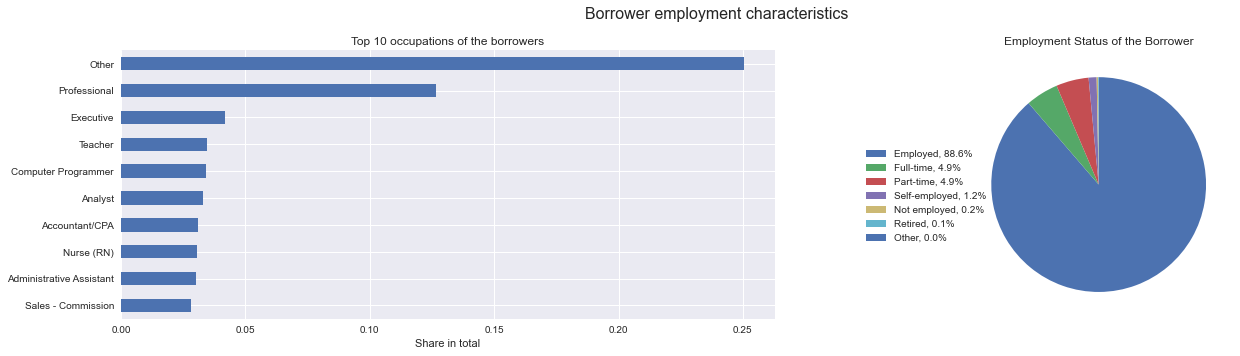

In [21]:
fig, axes = plt.subplots(1, 2, figsize =[20,5])
fig.suptitle('Borrower employment characteristics', fontsize = 16)

### PLotting top 10 occupations
df['Occupation'].value_counts(ascending = True, normalize = True).tail(10).plot.barh(ax= axes[0])
axes[0].set_title('Top 10 occupations of the borrowers')
axes[0].set_xlabel('Share in total')

### Plotting employment status
## First create shares and labels
shares = round(df['EmploymentStatus'].value_counts(normalize = True), 3)
labels = ['Employed', 'Full-time', 'Part-time', 'Self-employed', 'Not employed', 'Retired', 'Other']
labels = [f'{l}, {s:0.1f}%' for l, s in zip(labels, 100*shares)]
## Actual plot with respective labels in the legend
axes[1].pie(shares, startangle = 90, counterclock = False)
axes[1].set_title('Employment Status of the Borrower')
axes[1].legend(bbox_to_anchor=(-0.40, 0.25), loc='lower left', labels = labels)

fig.tight_layout()
plt.show();

Most of borrowers are employed. The data has some issues,  part or full should be considered as employed. Consequently, 99% of borrowers can be considered as employed. 

The most frequent borrowers are usually professionals as executive, teacher, programmer or analysts. 

### 1.7 What are the income characteristics of the borrowers?

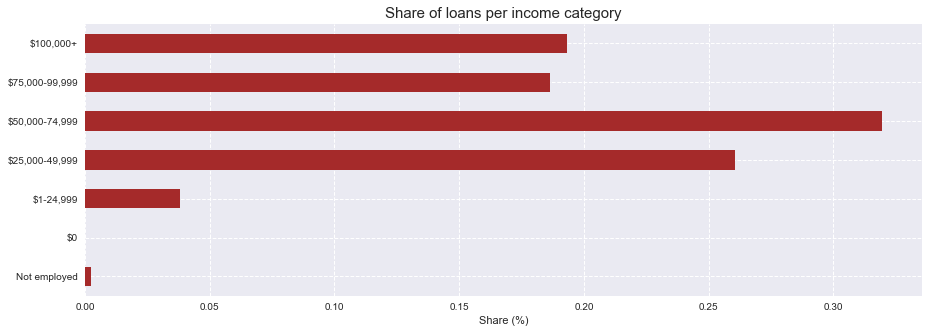

In [22]:
## Plotting income ranges
plt.figure(figsize = [15, 5])
x = df['IncomeRange'].value_counts(sort = False, normalize = True)
plot_bar(x, x_label = ('Share (%)'), title = 'Share of loans per income category')

Most of the borrowers are within income range higher than 25k. 

### 1.8 Borrower's debt / asset state

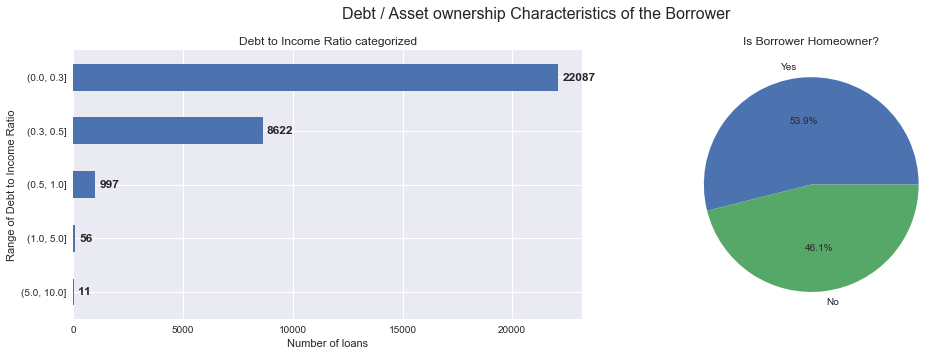

In [23]:
fig, axes = plt.subplots(1, 2, figsize =[15,5])
fig.suptitle('Debt / Asset ownership Characteristics of the Borrower', fontsize = 16)

### Plotting Debt to Income Ratio categorized by ranges
debt = pd.cut(df['DebtToIncomeRatio'], bins = [0, 0.3, 0.5, 1, 5, 10]) ## Creating range categories and cutting
shares = debt.value_counts(ascending = True)  ## Calculate shares within total loans

### Actual plot of shares
shares.plot.barh(ax = axes[0])
### Annotating each bar, adding title and changing labels
for i in range (len(shares)):
    count = list(shares)[i]
    axes[0].text(count+200, i, count, va = 'center', fontweight = 'bold', fontsize = 12)

axes[0].set_title('Debt to Income Ratio categorized')
axes[0].set_ylabel('Range of Debt to Income Ratio')
axes[0].set_xlabel('Number of loans')

### Plotting Home Ownership pie chart
df['IsBorrowerHomeowner'].value_counts(normalize = True).plot.pie(ax = axes[1], autopct='%1.1f%%')
axes[1].set_ylabel('')
axes[1].set_title('Is Borrower Homeowner?')

fig.tight_layout()
plt.show()

Low debt to income ratio is quite common. However, there are also large debt to income ratios. These outliers can not be removed, since higher debt to income ratio may point to efficiency of the borrower. Therefore, this may be correlated with greater investor numbers. More than half of the borrowers are home owners.

### 1.9 Borrower's credit history

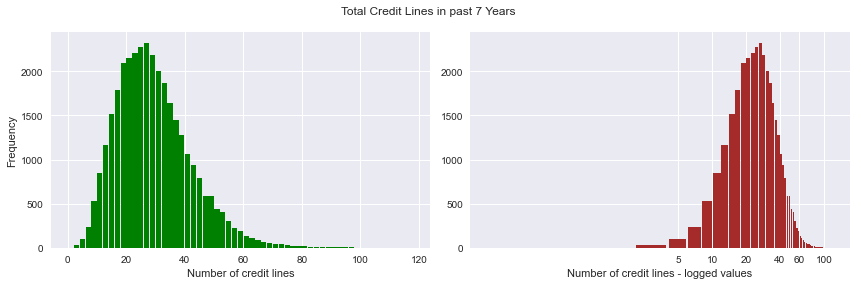

In [24]:
### PLotting number of credit lines in past 7 years
fig, axes = plt.subplots(1,2, figsize = [12,4])
binsize = 2
bins = np.arange(0, df['TotalCreditLinespast7years'].max()+binsize, binsize)
df['TotalCreditLinespast7years'].hist(bins = bins, ax = axes[0], color = 'green', rwidth = 0.9)
df['TotalCreditLinespast7years'].hist(bins = bins, ax = axes[1], color = 'brown', rwidth = 0.9)
fig.suptitle('Total Credit Lines in past 7 Years')
axes[0].set_xlabel('Number of credit lines')
axes[1].set_xlabel('Number of credit lines - logged values')
axes[1].set_xscale('log')
axes[1].set_xticks([5, 10, 20, 40, 60, 100], ['5', '10', '20', '40', '60', '100'])
axes[0].set_ylabel('Frequency')
fig.tight_layout()
plt.show()

Total credit lines in the past is skewed. Borrowers with 10 to 40 credit lines in the past are most frequent.

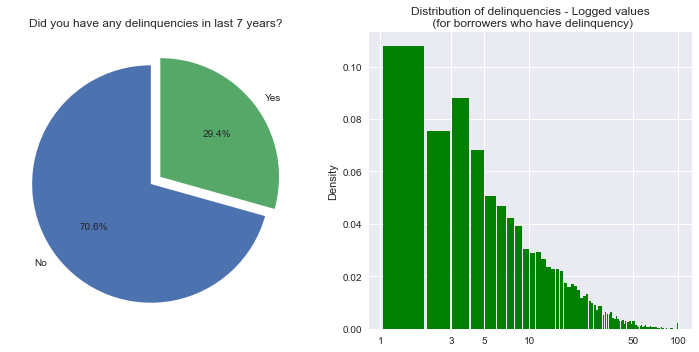

In [25]:
### PLotting number of delinquncies in past 7 years
fig, axes = plt.subplots(1,2, figsize = [10,5])

explode = (0.05, 0.05)
(df['DelinquenciesLast7Years']>0).value_counts(normalize = True).plot.pie(ax = axes[0], autopct='%1.1f%%', 
                                                                          startangle=90, explode = explode, 
                                                                          labels = ['No', 'Yes'])
axes[0].set_ylabel('')
axes[0].set_title('Did you have any delinquencies in last 7 years?')
#axes[0].set_legend(['Yes', 'No'])

binsize = 1
delinquency = df[df['DelinquenciesLast7Years']>0]['DelinquenciesLast7Years']
bins = np.arange(1, delinquency.max()+binsize, binsize)
delinquency.hist(bins = bins, ax = axes[1], color = 'green', density = True, rwidth = 0.9)
axes[1].set_xscale('log')
axes[1].set_xticks([1, 3, 5, 10, 50, 100], ['1', '3', '5','10', '50', '100'])
axes[1].set_title('Distribution of delinquencies - Logged values\n (for borrowers who have delinquency)')
axes[1].set_ylabel('Density')

fig.tight_layout()
plt.show()

Delinquency is observed among 30% of the  borrowers. For those who had delinquency in the past, majority of them have 1 to 5 delinquencies. The distribution also have some outliers with delinquency reaching to close to 100.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?
I will discuss distributions per each section as below.

<b> 1. Pofitability characteristics </b>

Investor numbers are quite skewed to the right, therefore I transformed data to log values. Many loans have only 1 investor, however loans with more investors between 20 to 50 are quite common. There are some outliers loans with investors close to 1000. Nevertheless, expected returns are quite symmetric. Outliers of investor number maybe related with loan amounts, so I did not removed them. 

<b> 2. Loan conditions </b>

Borrower rates are distributed quite symmetric similar to expected returns. Most of the loans are taken for 3 or 5 year terms. Loans under 1 year term amount to less than 5% of the observations. Borrowers are mostly borrowing for debt consolidation (more than 70% of loans). Other frequent categories are home improvement, business, household expenses and medical/dental. Top 5 categories of loans amount to 87.7% of total loans. Amount of loans have unequal distribution. Distribution have spikes at loans which amount to \\$5000, \\$10000, \\$15000, \\$20000 and \$25000. Outliers are crowded around \\$35000. These outliers may be related with outliers in the investor numbers.

<b> 3. Borrower characteristics </b>

Borrowers are mostly employed (99\%) and earning under income category greater than \$25000. Moreover most frequent borrowers are professionals, teachers, executives and analysts. Geographically, most frequent borrowers are from CA, TX, FL, NY and IL, which is not suprising since theses are the biggest states in terms of population. About 54\% of the borrowers are homeowners. Debt to income ratio is also quite skewed to the right. Most of the borrowers owe less than 30\% of their income. From the point of credit history, not many borrowers have delinquency in the past 7 years (74\%). Those who have delinquency, the number of delinquency is less than 5 times. However, many borrowers had quite high number (over 20) of open credit lines in the past 7 years. 

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

In order to conduct preliminary investigation following tidying and adjustments have been conducted.
1. Due to skewed distributions I transformed data into logged values for following variables: number of investors, debt ot income ratio, open credit lines and delinquency in the past 7 years.
2. I made income category an ordered type.
3. Category of loans was given in numbers. So I created text categories for loans using kaggle web site.
4. Created a categorical ordered column for debt to income ratio.
5. Converted boolean 'IsBorrowerHomeowner' variable into string type.

## Bivariate Exploration
<a id = '4'></a>

### 2.1 Estimated Return and Investor Numbers 

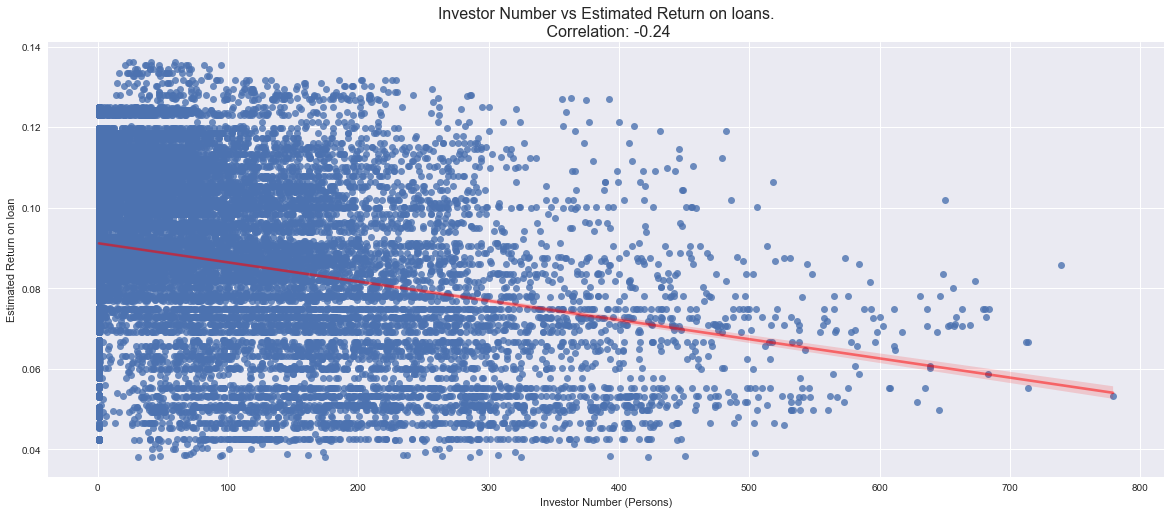

In [26]:
## PLotting a scatter plot with fitted line
x = 'Investors'
y = 'EstimatedReturn'
corr = df[[x,y]].corr()[x][y] ## Correlation coefficient
plt.figure(figsize = [20,8])

sb.regplot(data = df, x=x, y = y, fit_reg = True, line_kws = {"color": "red", 'alpha': 1/2}, x_jitter = 0.3)
plt.title('Investor Number vs Estimated Return on loans.\n Correlation: {}'.format(corr.round(2)), fontsize = 16)
plt.xlabel('Investor Number (Persons)')
plt.ylabel('Estimated Return on loan')
plt.show();

Investor number is negatively related with estimated return on loans. It is possible that bigger loans have more investors, since financing such loans can not be acomplished by single investor. Since bigger loans have lower returns due to its size, it also have more investors.

### 2.2 Investor number and Loan characteristics
#### Term, Borrower rate

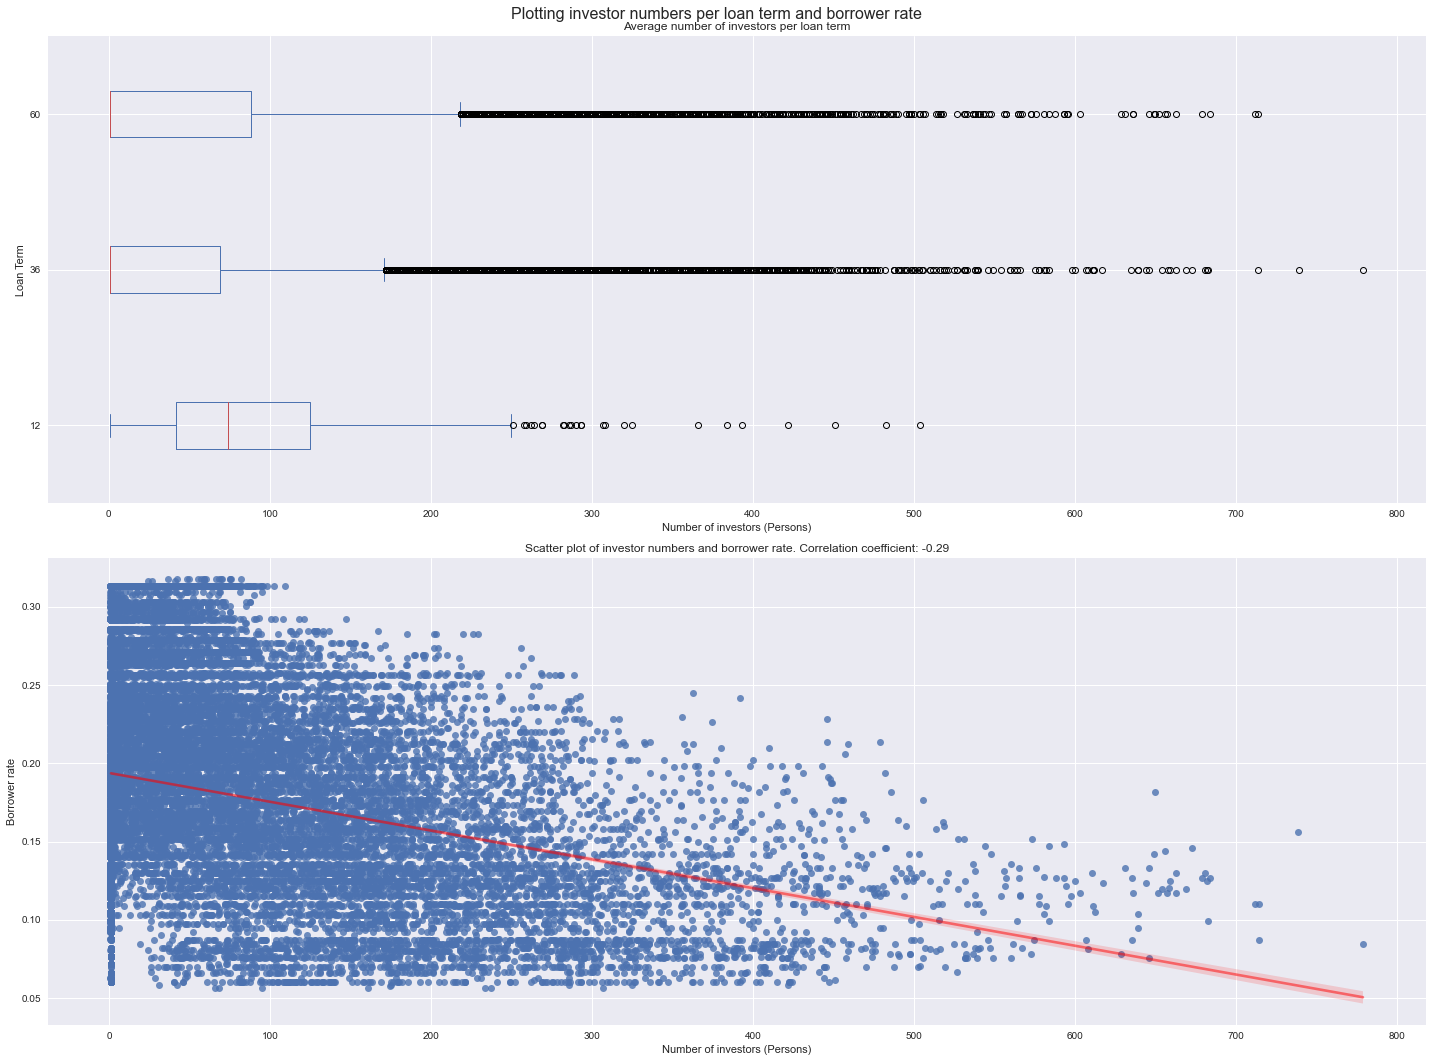

In [27]:
fig, axes = plt.subplots(2,1, figsize = [20,15])
fig.suptitle('Plotting investor numbers per loan term and borrower rate', fontsize = 16)

x = 'Investors'
y = 'Term'

df.plot.box(column = x, by = y, ax = axes[0], vert = False)
axes[0].set_xlabel('Number of investors (Persons)')
axes[0].set_title('Average number of investors per loan term', fontsize =12)
axes[0].set_ylabel('Loan Term')

y = 'BorrowerRate'
corr = df[[x,y]].corr()[x][y].round(2)
sb.regplot(data = df, x=x, y=y, fit_reg=True, ax=axes[1], 
                                  line_kws={"color": "red", 'alpha': 1/2}, x_jitter = 0.3)
axes[1].set_xlabel('Number of investors (Persons)')
axes[1].set_ylabel('Borrower rate')
axes[1].set_title('Scatter plot of investor numbers and borrower rate. Correlation coefficient: {}'.format(corr), fontsize =12)

fig.tight_layout()
plt.show();

On average there is negative correlation between borrower rate and investor numbers (Similar to expected return). Among terms, the less frequent term has the highest average investor numbers. However, terms 36 and 60 suffer from outlier issue. 

### 2.3 Loan Original Amount.
As expected, larger loans have more investors due to its scale.

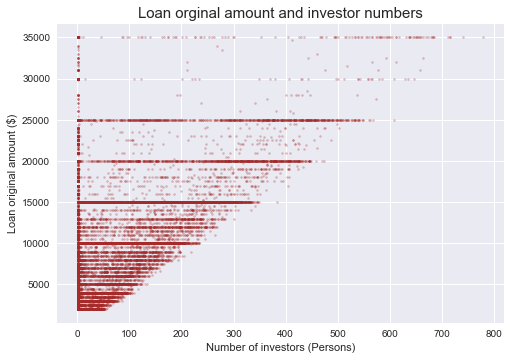

In [28]:
x = 'Investors'
y = 'LoanOriginalAmount'

plot_scatter(df, x, y, x_label = 'Number of investors (Persons)',
            y_label = 'Loan original amount ($)', 
            title = 'Loan orginal amount and investor numbers')

Larger loans have more investors on average.

### 2.4 Loans per category

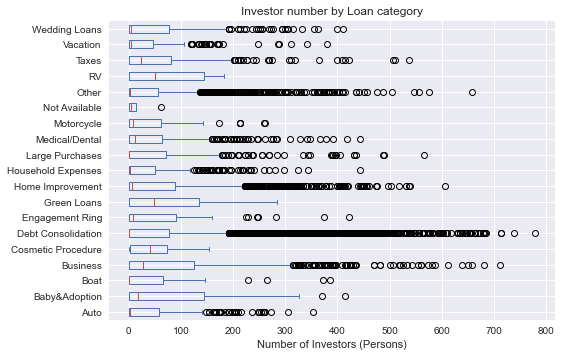

In [29]:
x = 'Investors'
y = 'ListingCategory (text)'
df.plot.box(column = x, by = y, vert = False)
plt.title('Investor number by Loan category')
plt.xlabel('Number of Investors (Persons)')
plt.show()

Loans with RV, Green loans and cosmetic procedure looks attracting more investors. It may also be related with their financing size. They tend to be bigger on average and require more investors to finance.

### 2.5 Occupation

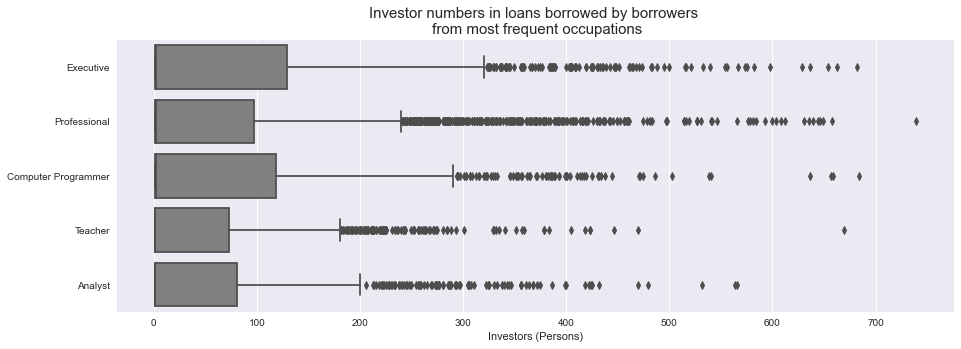

In [30]:
x = 'Investors'
y = 'Occupation'
## Listing most frequent occupations found in previous section
most_freq_occupation = ['Professional', 'Executive', 'Teacher', 'Computer Programmer', 'Analyst']
data = df[df.Occupation.isin(most_freq_occupation)] ## Subsetting dataset

plt.figure(figsize = [15,5])

def plot_boxplot(df, x_col, y_col, title = '', x_label = ''):
    """ This is a function to plot a box plot via seaborn package.
    
    Args:
        df - Dataframe name
        title - title of the plot
        x_col, y_col - columns on x and y axis respectively
        x_label - labels for x and y axis respectively
    Returns:
        box plot
    """
    sb.boxplot(data = df, x=x_col, y=y_col, color = 'gray')
    plt.title(title, fontsize = 15)
    plt.xlabel(x_label)
    plt.ylabel('')
    plt.show()

plot_boxplot(data, x, y, title = 'Investor numbers in loans borrowed by borrowers \n from most frequent occupations',
            x_label = 'Investors (Persons)')

Executives and programmers are more likely to secure loans with greater investor numbers. Although on average occupation does not make much difference.

### 2.6 Income range

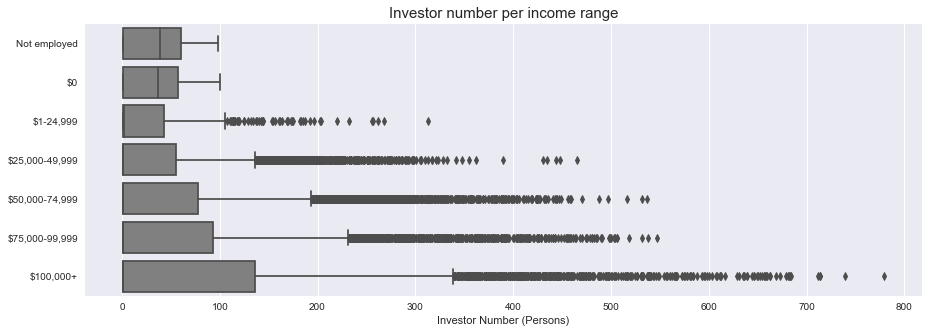

In [31]:
x = 'Investors'
y = 'IncomeRange'
plt.figure(figsize = [15, 5])

plot_boxplot(df, x, y, title = 'Investor number per income range',
            x_label = 'Investor Number (Persons)')

The higher the income the greater the investor numbers.

### 2.7 Homeownership

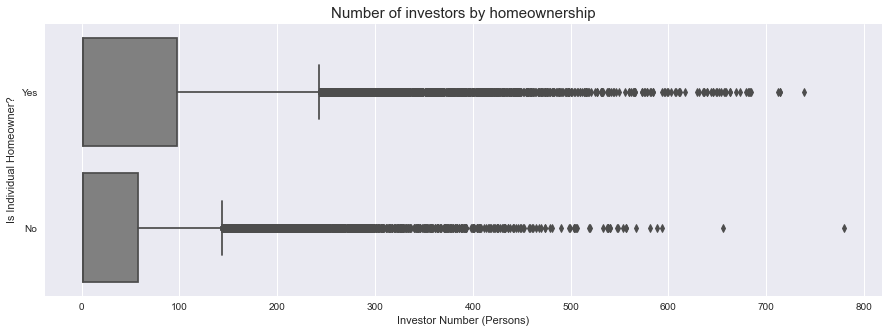

In [33]:
x = 'Investors'
y = 'IsBorrowerHomeowner'
plt.figure(figsize = (15,5))

sb.boxplot(data = df, x=x, y=y, color = 'gray')
plt.title('Number of investors by homeownership', fontsize = 15)
plt.xlabel('Investor Number (Persons)')
plt.ylabel('Is Individual Homeowner?')
plt.show()

Homeowners might have more loans with greater investors.

### 2.8 Debt to Income Ratio

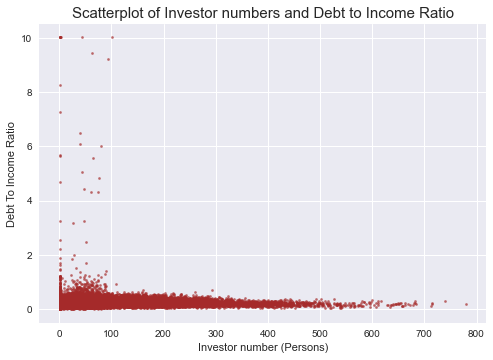

In [34]:
x = 'Investors'
y = 'DebtToIncomeRatio'

plot_scatter(df, x, y, x_label = 'Investor number (Persons)', 
            y_label = 'Debt To Income Ratio',
            title = 'Scatterplot of Investor numbers and Debt to Income Ratio',
            alpha = 0.7, s = 5)

### 2.9 Credit history

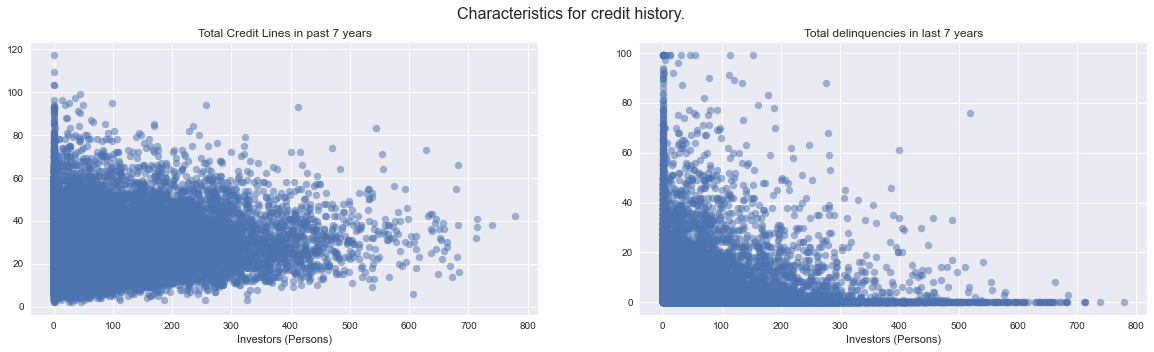

In [35]:
fig, axes = plt.subplots(1,2, figsize = [20, 5])
x = 'Investors'
fig.suptitle('Characteristics for credit history.', fontsize = 16)

y = 'TotalCreditLinespast7years'
axes[0].scatter(df[x], df[y], alpha = 0.5)
axes[0].set_xlabel('Investors (Persons)')
axes[0].set_title('Total Credit Lines in past 7 years')

y = 'DelinquenciesLast7Years'
axes[1].scatter(df[x], df[y], alpha = 0.5)
axes[1].set_xlabel('Investors (Persons)')
axes[1].set_title('Total delinquencies in last 7 years')

plt.show()

In [ ]:
df[['Investors', 'TotalCreditLinespast7years','DelinquenciesLast7Years']].corr()

## Some additional observation
Correlation plot borrower rate and loan size

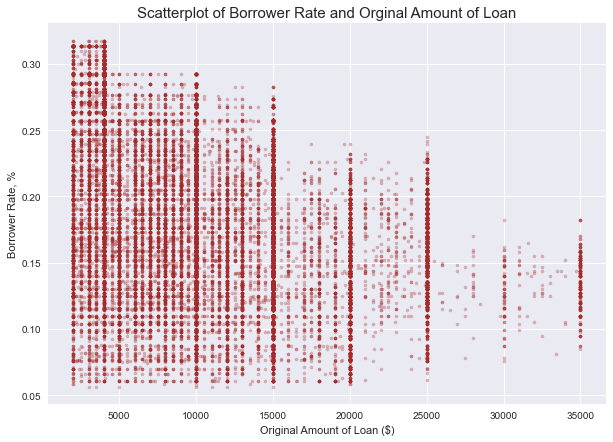

In [36]:
y = 'BorrowerRate'
x = 'LoanOriginalAmount'

plt.figure(figsize  = [10,7])
plot_scatter(df, x, y, y_label = 'Borrower Rate, %', 
            x_label = 'Original Amount of Loan ($)',
            title = 'Scatterplot of Borrower Rate and Orginal Amount of Loan', s = 10)

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

- From above relationship plots we see that there is strong negative correlation with investor numbers and expected returns and borrower rates. This might be also related with loan sizes. In fact, larger loans have greater number of investors. Possibly, larger loans might have lower borrower rates and expected returns also. Big key purchases such as green loans, RV or cosmetic procedures are related with greater investors, probaly again due to their bigger size of finance.

- From the point of loan terms, smaller terms (1 year) have on average greater investor numbers. However, their share is very low, so we can not conclude this as non random. 

- Borrower characteristics also do not give much information. By occupation, programmers and executives look to secure loans with more investors to finance. Moreover, higher earning individuals also securing loans with greater number of investors.

- Homeownership, on average do not differ in investor numbers. But at upper distribution investor numbers, owning a home works as a positive sign.

- Interestingly, credit history have very weak correlation with investor numbers. This probably, because the observations are mostly consist of low level of delinquency loans.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

As expected, correlation of borrower rate and loan size is negatively correlated. Meaning the greater the loan size the less is the expected return. However, it might also have greater loan security to back up.

## Multivariate Exploration
<a id='5'></a>

During above investigations I see that investor numbers are very highly correlated with expected returns, borrower rate, homewonership, loan category and original amount of loan size. Here, I will create a plot using these variables. Since expected return and borrower rate is highly correlated with each other, I will drop expected return from analysis.
We will first look at scatter plot of borrower rate and investor numbers by homeownership.

### 3.1 Plotting Borrower rate, Investor Number, Loan size and Homeownership 

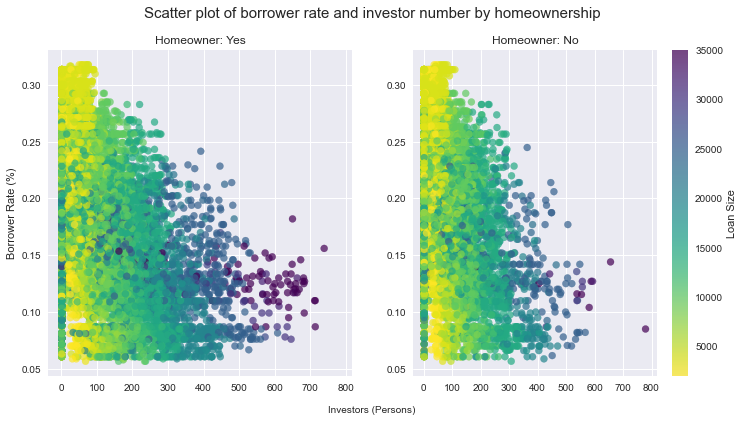

In [37]:
x = 'Investors'
y = 'BorrowerRate'
c = 'LoanOriginalAmount'
z = 'IsBorrowerHomeowner'
## Creating subsets of data by homeownership
df_y = df[df.IsBorrowerHomeowner == 'Yes']
df_n = df[df.IsBorrowerHomeowner == 'No']
## Plotting side by side with a colorbar
fig, axes = plt.subplots(1, 2, figsize =[12,6], sharex=True)
fig.suptitle('Scatter plot of borrower rate and investor number by homeownership', fontsize = 15)
left = axes[0].scatter(data = df_y, x=x, y=y, c = c, cmap = 'viridis_r', alpha  = 0.7)
right = axes[1].scatter(data = df_n, x=x, y=y, c = c, cmap = 'viridis_r', alpha  = 0.7)
fig.colorbar(right, label = 'Loan Size')
axes[0].set_title('Homeowner: Yes')
axes[1].set_title('Homeowner: No')
axes[0].set_ylabel('Borrower Rate (%)')
fig.text(0.5, 0.04, 'Investors (Persons)', ha='center')
plt.show()

### 3.2 Loan size and investor number by most frequent loan category

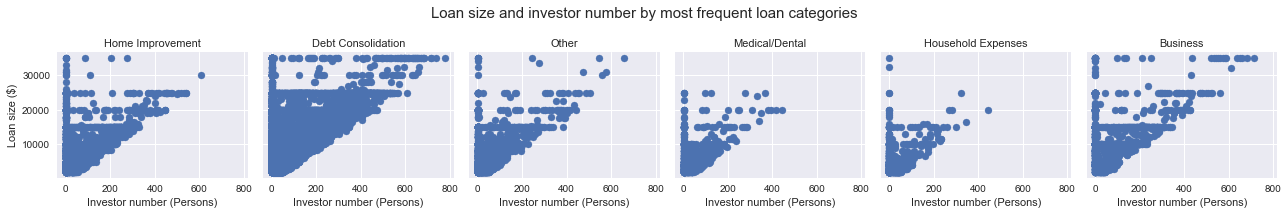

In [38]:
x = 'Investors'
y = 'LoanOriginalAmount'

most_freq_category = ['Debt Consolidation', 'Home Improvement', 'Business', 'Other', 'Household Expenses', 'Medical/Dental']
data = df[df['ListingCategory (text)'].isin(most_freq_category)] ## Subsetting dataset


g = sb.FacetGrid(data = data, col = 'ListingCategory (text)')
g.map(plt.scatter, x, y)

g.set_axis_labels("Investor number (Persons)", "Loan size ($)")
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Loan size and investor number by most frequent loan categories', fontsize = 15)

g.tight_layout()

plt.show()

Debt consolidation and Business categories are more likely to have large size loans and consequently more investors.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

Above plots show that larger loans are indeed attract more loans, even though the interest rates are lower. This might be explained in a way, that larger loans are usually have stronger protection in terms of finance. For example, in the second plot we see that homeowners (big asset owners) have more larger loan sizes. 
Additionaly, loans under category of business or debt consolidation are also going to be correlated with more investors since they also have many large size loans.

### Were there any interesting or surprising interactions between features?

Interestingly, there are borrowers who are not homeowners, but still have large loans with many investors.

## Conclusions
<a id = '6'></a>
During this project I investigated factors defining investor numbers per loan. I used Prosper dataset from peer-to-peer lending service web site. To investigate the question, among full data set I chose 15 variables including variable of interest (investor number) and restricted the sample period to year 2013. I investigated the question along three aspects of invesments consideration: profitablity, loan conditions and borrower background. I started with looking at distribution of each variable and then plotting them against main variable of interest.
- From profitablity point, expected return of the loan is negatively correlated with investor numbers. This is closely related with loan size. In fact, bigger loans have  more investors and at the same time larger loans have lower interest rates.

- From loan term conditions, I have the same finding regarding borrower rates. That is borrower rate is also strongly negatively correlated with investor numbers which again can be explained with larger loans having more investors and lower rates.

- Employment characteristics and borrower states have many noisy data and do not bring meaningful observations. Higher income earners are securing loans with greater investors.

- As already noted, loan size is strongly correlated with investor number and also with borrower interest rates. It looks like that greater loans might have stronger security. this can be seen in the last scatterplot where we can devide borrowers into homeowners and not homeowners. Homeowner borrowers have more security to guarantee a loan payback, hence they may secure larger loans and consequently loans are financed by more investors. 

- Among most frequent loan categories, loans under debt consolidation and business is correlated with more investors. This is also coming from the fact that there more large size loans under this categories. Therefore, they attract more investors.

## References
<a id = 'ref'></a>
1. Source for converting loan category from number to text - [link](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0)